# Appentissage supervisé pour des données avec classes désequilibrées.

In [1]:
import sys
assert sys.version_info >= (3, 7)

In [2]:
import pandas as pd
from src.core.model.Processing import Processing
from src.core.model.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

cwd = Path.cwd()
PROJECT_PATH = cwd.parent.parent.parent
DATA_PATH = PROJECT_PATH / "data"
IMAGES_PATH = PROJECT_PATH /  "images"

print(DATA_PATH)
print(IMAGES_PATH)
%load_ext autoreload
%autoreload 2

/home/godwin/Documents/Uparis/M1MLSD/ue_app-machine/unbalanced-data-ml


In [3]:
file_path=f"{DATA_PATH}/creditcard.csv"
sep=","
outcome="Class"
positive_mod="1"

df = pd.read_csv(file_path,sep=sep)

And let's create the images/svm folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res

In [4]:
# UEDA means: Unbalanced Exploratory Data Analysis

IMAGES_UEDA_PATH = IMAGES_PATH / "ueda"
IMAGES_UEDA_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_UEDA_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Analyse exploratoire des données déséquilibrées

In [5]:
process = Processing() # object which do processing for df
analyzer = Analyser() # object which give graphics, statistics indicators for df

### Analyse exploratoire des attributs du dataset -_- Credit fraud

In [6]:
df.shape

(284807, 31)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# checking missing values
process.summary(df)

{'Missing Values': Time      0
 V1        0
 V2        0
 V3        0
 V4        0
 V5        0
 V6        0
 V7        0
 V8        0
 V9        0
 V10       0
 V11       0
 V12       0
 V13       0
 V14       0
 V15       0
 V16       0
 V17       0
 V18       0
 V19       0
 V20       0
 V21       0
 V22       0
 V23       0
 V24       0
 V25       0
 V26       0
 V27       0
 V28       0
 Amount    0
 Class     0
 dtype: int64,
 'Constant Features': []}

In [9]:
df[outcome] = df[outcome].astype(str) # cast outcome to qualitative variable

the dimension of df is (284807,31)
We can see that they don't have any missing values and constant features

#### Adapted plot for class
---

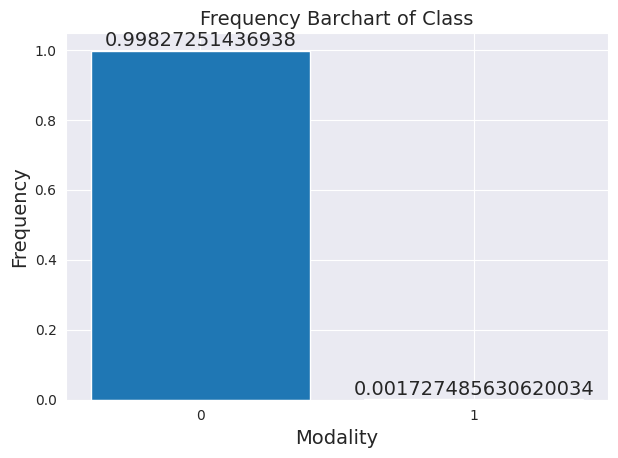

In [29]:
_, ax = plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)
# save image
save_fig("class_barplot")
plt.show()

##### Conclusion
We can see above that, Class attribute is very imbalanced ( 0.998 for modality "0")

#### Adapted plot for numerical columns
---

##### Boxplot

In [9]:
analyzer_summary = analyzer.summary(df)
quantitative_features, _ = \
    analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

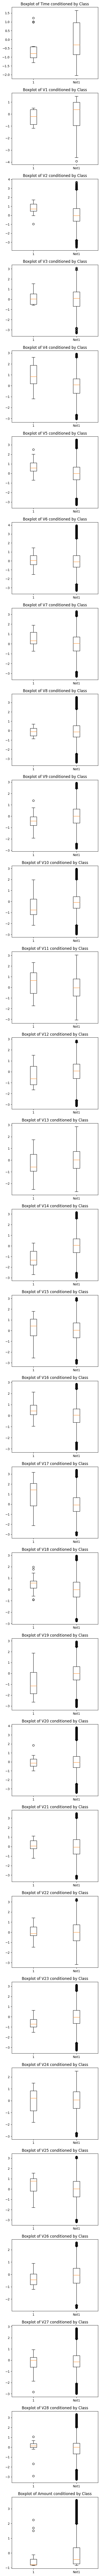

In [10]:
# we decided to remove outliers before boxplot creation
df = process.remove_outliers(df)

# we also standardize quantitative features
df[quantitative_features] = process.standard_scaler(df[quantitative_features])

fig, axs = plt.subplots(
    nrows = len(quantitative_features),
    figsize = (5,len(quantitative_features)*5)
)

# we iterate through variable's list length in order to plot boxplot graph
for i in range(len(quantitative_features)):
    analyzer.prop_churn_by_numerical_boxplot(
        df,
        outcome,
        positive_mod,
        quantitative_features[i],
        axs[i]
    )

- Due to important numbers of features, we select variables with low, no influence for Class outcome:
    - **Not/low influence**: ["V22","V21","V19","V3"]

##### Conclusion -relevant quantitative features:

All except ["V22","V21","V19","V3"], to prevent overfitting risk, we are going to select a sub set of features most influential for Class outcome

#### Correlation Matrix
---

In [11]:
relevant_features =\
    list(set(quantitative_features).difference({"V22","V21","V19","V3"}))

# we decided to work with only relevant features for Attrition
df_new = df[[outcome]+relevant_features]

<Axes: >

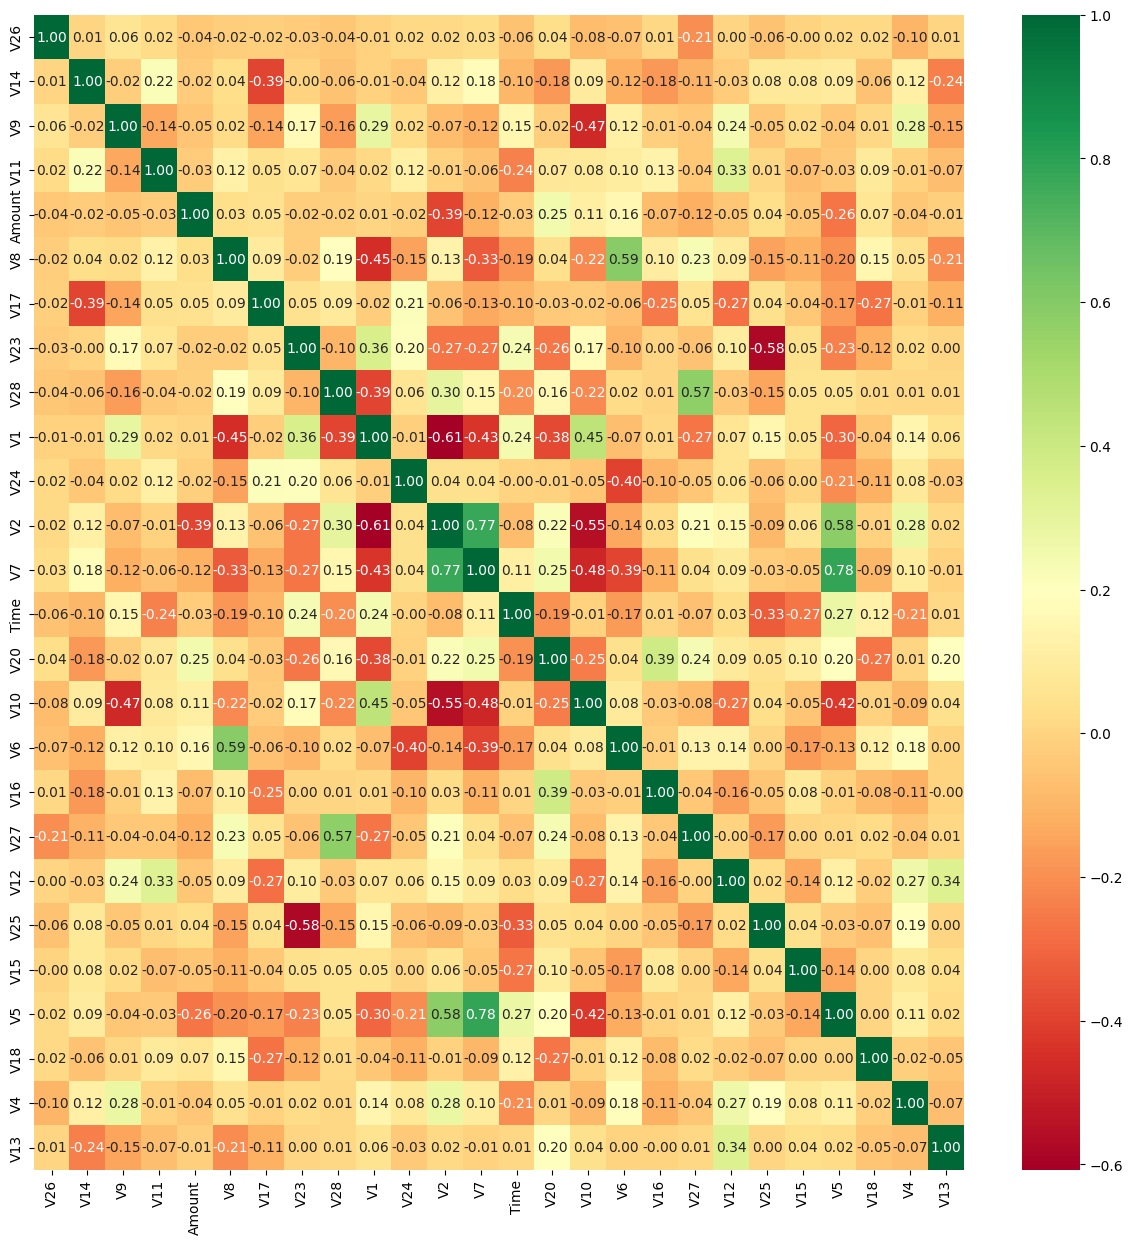

In [12]:
plt.figure(figsize=(15,15))
analyzer.correlation_heatmap(df_new,annot=True)

##### Correlation Matrix - Strength correlated features

In [13]:
correlations = df_new.corr(numeric_only=True)
groups = {1:.3,2:.5,3:.5}
"""
high correlation (>=.5): group3
medium correlation (>=.3 and <.5): group2
low correlation (<.3):group1
"""
print()

In [14]:
dict_correlations = {key:[] for key in groups.keys()}
rows = cols = None

for group in groups.keys():
    if group == 1:
        rows, cols = np.where(np.abs(correlations) < groups[group])
    elif group == 2:
        rows, cols = np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group == 3:
        rows, cols = np.where(np.abs(correlations) >= groups[group])

    dict_correlations[group] = \
        [
            (
                correlations.index[row],
                correlations.columns[col],
                correlations.iloc[row, col]
            )
            for row, col in zip(rows, cols) if row != col
        ]

In [15]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('V26', 'V14', 0.005035779856902632),
  ('V26', 'V9', 0.05885045425547585),
  ('V26', 'V11', 0.020900189932294776),
  ('V26', 'Amount', -0.037230643708316184),
  ('V26', 'V8', -0.020627619640005646),
  ('V26', 'V17', -0.016323282903188793),
  ('V26', 'V23', -0.025379439003607947),
  ('V26', 'V28', -0.04310385926630894),
  ('V26', 'V1', -0.006017283923692628),
  ('V26', 'V24', 0.016947416054416194),
  ('V26', 'V2', 0.01621975869604075),
  ('V26', 'V7', 0.03180445113093085),
  ('V26', 'Time', -0.05526555444027267),
  ('V26', 'V20', 0.035376398813654834),
  ('V26', 'V10', -0.07813234331899212),
  ('V26', 'V6', -0.06575379923235058),
  ('V26', 'V16', 0.008470338982126917),
  ('V26', 'V27', -0.20545894749594953),
  ('V26', 'V12', 0.004255656042286602),
  ('V26', 'V25', -0.06031203775749486),
  ('V26', 'V15', -0.001008693738790907),
  ('V26', 'V5', 0.01798384756097704),
  ('V26', 'V18', 0.015687377039190147),
  ('V26', 'V4', -0.10133556257315379),
  ('V26', 'V13', 0.005316861500560569),

We can see that this tuple features have abs(correlation)>=.5
[
  ('V23', 'V25', -0.5812886668266443),
  ('V1', 'V2', -0.607644959168512),
  ('V8', 'V6', 0.5861803360059155),
  ('V28', 'V27', 0.5736721045524082),
  ('V5', 'V2', 0.5841723999780843),
  ('V5', 'V7', 0.7820080661264317),
  ('V2', 'V10', -0.5535632809828112),
  ('V2', 'V7', 0.7692226619224113)
]

We decided to remove ["V23","V1","V8","V27","V5","V2"] to avoid as much as possible correlations between features

In [16]:
removed_features = ["V23","V1","V8","V27","V5","V2"]
relevant_features = [f for f in relevant_features if f not in removed_features]
df_new_ = df_new[[outcome]+relevant_features]

In [17]:
process.summary(df_new_)

{'Missing Values': Class     0
 V26       0
 V14       0
 V9        0
 V11       0
 Amount    0
 V17       0
 V28       0
 V24       0
 V7        0
 Time      0
 V20       0
 V10       0
 V6        0
 V16       0
 V12       0
 V25       0
 V15       0
 V18       0
 V4        0
 V13       0
 dtype: int64,
 'Constant Features': []}

In [18]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['Class'],
  'quantitative_columns': ['V26',
   'V14',
   'V9',
   'V11',
   'Amount',
   'V17',
   'V28',
   'V24',
   'V7',
   'Time',
   'V20',
   'V10',
   'V6',
   'V16',
   'V12',
   'V25',
   'V15',
   'V18',
   'V4',
   'V13']},
 'describe':                 V26           V14            V9           V11        Amount  \
 count  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05  1.463340e+05   
 mean  -1.320729e-17  2.486079e-17 -1.243039e-17  2.641459e-17 -6.992097e-17   
 std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
 min   -2.703360e+00 -2.970104e+00 -2.814511e+00 -3.053924e+00 -8.343829e-01   
 25%   -6.953992e-01 -6.164755e-01 -5.984735e-01 -8.065453e-01 -7.296545e-01   
 50%   -6.094479e-02  7.235201e-02  1.801707e-03 -2.805937e-02 -4.381844e-01   
 75%    5.100891e-01  6.757540e-01  6.263627e-01  7.959260e-01  3.611466e-01   
 max    2.576936e+00  3.152575e+00  2.911573e+00  3.051164e+00  3.577121e+

## Prédiction de churn, Partie I

In [20]:
from src.core.model.ComputeModel import ComputeModel
from src.core.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="1"
models=\
    {
        "Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
    }

In [21]:
# we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters = copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"] = "liblinear"
    else:
        hyperparameters = None

    models[model_name] = ComputeModel(
        df_new_[relevant_features],
        df_new_[outcome],
        process = process,
        model_name = model_name,
        hyperparameters = hyperparameters,
        positive_mod = positive_mod
    )
    models[model_name].fit()

/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


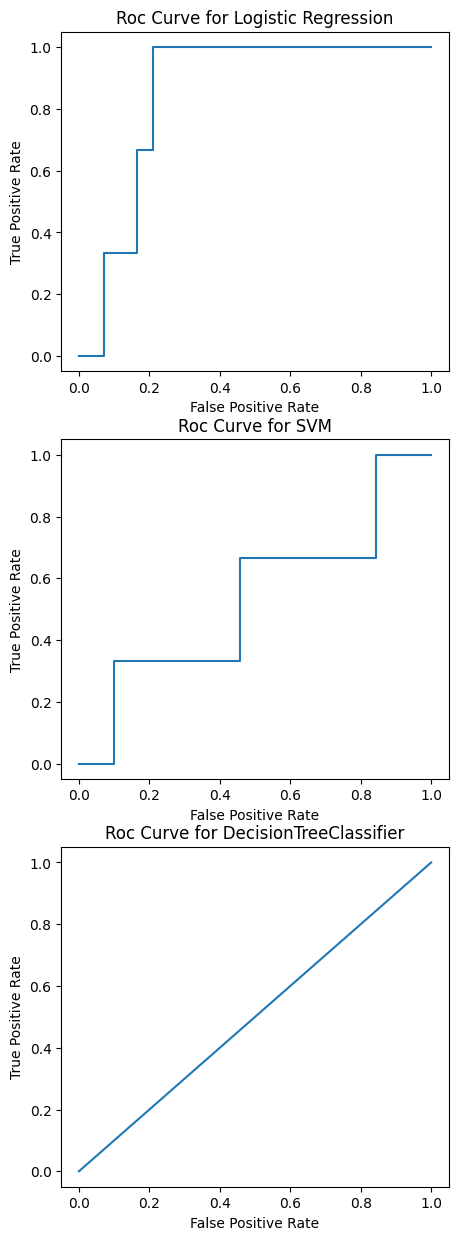

In [22]:
fig, axs = plt.subplots(
    nrows=len(models.keys()),
    figsize=(5,5*len(models.keys()))
)
metrics_default = \
    {
        list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))
    }

In [23]:
metrics_default

{'Logistic Regression': {'auc': 0.8511937306360489,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.533465463823583,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4999145708037179,
  'accuracy': 0.9997266545939112,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

# In conclusion:

we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression is the best model because AUC of this model (~0.85) is significantly bigger than auc for 2 others models
- We can see that probability to be positive is very, very low, consequently recall and precision are equal to 0 because dataset is very, very imbalanced (~99.8% negative ~0.02% positive)
- To conclude, models are not efficient for this dataset, we need to have an oversampling/under sampling methods to balanced majority and minority class for Class outcome, we have decided to actually work with imbalanced dataset in this sequence because in sequence 4, we will see over/under sampling methods
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyper-parameters)




In [24]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["lbfgs"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [200,250]
            },
        "SVM":
            {
                "kernel": ["poly", "rbf", "sigmoid"],
                "C": [0.1, 1, 10, 100],
                "degree": [3],
                "gamma": [1, 0.1, 0.01, 0.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2, 3, 4],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None]+list(range(2, 100)),
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }

    }


In [25]:
# we used three fold-cross validation with a params default grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name] = ComputeModel(
        df_new_[relevant_features],
        df_new_[outcome],
        process=process,
        model_name=model_name,
        positive_mod=positive_mod,
        grid_search=True,
        cv=3,
        params_grid=params_grid[model_name]
    )

    models[model_name].fit()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 297 candidates, totalling 891 fits


/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khaldi/.cache/pypoetry/virtualenvs/app-machine-WNt7oxYU-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

{'Logistic Regression': {'auc': 0.5720794605431019,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'SVM': {'auc': 0.7465600510297066,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 'DecisionTreeClassifier': {'auc': 0.4994190814652816,
  'accuracy': 0.9998974954727167,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0}}

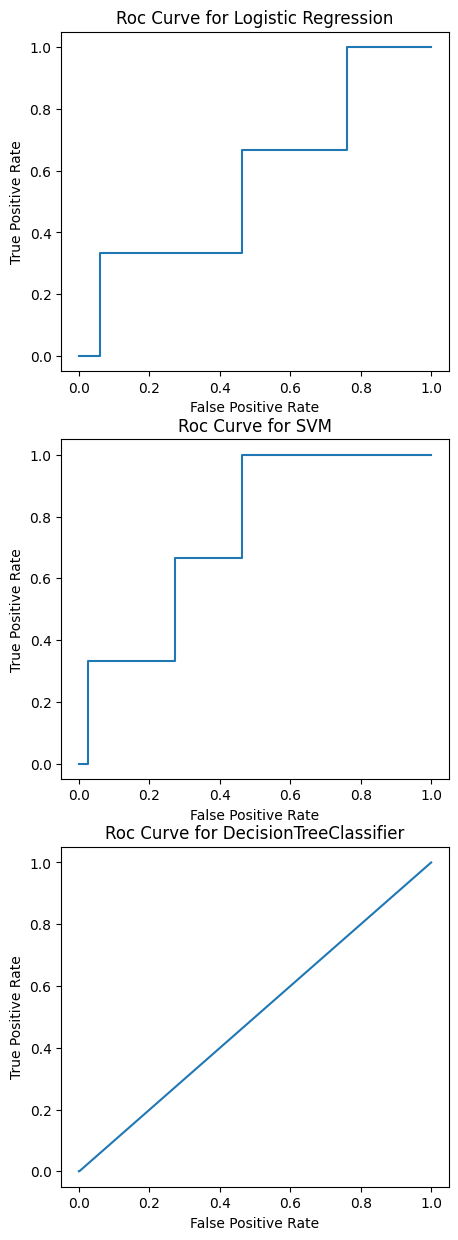

In [32]:
fig, axs = plt.subplots(
    nrows=len(models.keys()),
    figsize=(5,5*len(models.keys()))
)
metrics =\
    {
        list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))
    }
metrics

In [33]:
resume_tuned = pd.DataFrame(metrics)
resume_default = pd.DataFrame(metrics_default)

In [34]:
pd.concat([resume_tuned.T,resume_default.T])\
    .reset_index()\
    .groupby("index")\
    .agg(lambda x:[a for a in x])
#first component of tuple is indicator for hyperparameters tuning

,auc,accuracy,precision,recall,f1_score
index,,,,,
DecisionTreeClassifier,"[0.4994190814652816, 0.4999145708037179]","[0.9998974954727167, 0.9997266545939112]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
Logistic Regression,"[0.5720794605431019, 0.8511937306360489]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"
SVM,"[0.7465600510297066, 0.533465463823583]","[0.9998974954727167, 0.9998974954727167]","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]"


- We can see that SVM are significantly improve in terms of performance (auc: 0.533 to .746), DecisionTreeClassifier stay at the same order of values.
  But with tuning, LogisticRegression, auc increase, accuracy, precision, recall, f1_score stay equal to 0
- An important things: metrics after tuning are more reliable because a 3-fold cross validation are set up during training whereas with default hyperparameters this 3 cross validation was not done (1 test set and 1 training set), that's why some indicators don't increase after tuning.
- Conclusion: even if you are using grid search, the best model for each three type of model don't resolve the problem of imbalance dataset;
  We need to equilibrate dataset and after train a model, I think that they are a huge imbalance between majority and minority modality for Class outcome
  and consequently all 3 models don't see minority class and predict always majority class.
  SVM with 3 cross validation (auc~0.746) seems to be the best of all models trained (they are Logistic Regression with auc ~ 0.85, but it was not trained with 3 cross validation implies that he is less reliable (to generalize at global populations)

In [38]:
hyperparameters_tuned = {
    list(models.keys())[i]:models[list(models.keys())[i]].model.hyperparameters for i in range(len(models.keys()))
}

In [39]:
best_model, hyperparameters = models["SVM"], hyperparameters_tuned["SVM"]

## Prédiction de churn, Partie II